Alexandre CHEVAUX & Virgile AMATO

### Introduction

Import des librairies 

In [27]:
# pour la fonction persp3d
require("rgl")
# pour la fonction quad2d
require("pracma")

# si les packages ne sont pas encore installé : décommentez ces lignes en fonction
# du packages voulu
#install.packages("rgl")
#install.packages("pracma")

On se propose, dans ce projet, d'étudier différentes méthodes d'estimation d'intégrales, pour des fonctions bi-variées.

Ainsi, La fonction que nous étudierons tout au long de ce projet est la suivante : 

In [28]:
h = function
    (x, y)
{
  return(1 + log(x + y) * 2 * x)
}

on affiche la fonction en 3D afin de l'étudier, en ayant défini au préalable son domaine de définition (support).

Nous choisissons de définir la fonction sur (x, y) --> [0, 2] x [0, 3] 

Cela nous permet d'étudier la forme globale de la fonction dans l'espace, ainsi que d'observer son domaine d'arrivée sur le support choisi :

In [4]:
persp3d(h,
        xlim=c(0, 2),
        ylim=c(0, 3),
        main="fonction h",
        ylab="y",
        xlab="x")

On définit certains paramètres, notamment le maximum de la fonction, en analysant le graphe 3d de la fonction

In [29]:
# nombres totales de simulations
n = 1000
# bornes de l'espace de définition de X
inf_x = 0
sup_x = 2
# bornes de l'espace de définition de Y
inf_y = 0
sup_y = 3
# En regardant la fonction dans persp3d, on peut voir que h est à valeurs dans [0, 8]
inf_v = 0
sup_v = 8

Nous souhaitons approximer l'intégrale de cette fonction (fonction de 2 variables donc double intégrale), qu'on note H.
Nous utiliserons pour celà 4 méthodes, que nous comparerons, notamment en terme de vitesse d'éxecution, de vitesse de convergence, et de biais.
Les 4 méthodes utilisées sont : 
- Méthode du Rejet
- Méthode de Monte-Carlo
- Méthode de la Fonction de Répartition inverse
- Méthode de la Copule

On calcul dans un premier temps la "vrai valeur" de la double intégrale de h (noté, pour rappel H),
à l'aide d'une fonction R : quad2d
- quad --> permet de calculer une intégrale simple
- quad2d --> permet de calculer une intégrale double
- quad3d --> permet de calculer une intégrale triple

In [30]:
H = quad2d(h, inf_x, sup_x, inf_y, sup_y)
paste("Vraie valeur de l'intégrale de h : ", H)

[1] "Vraie valeur de l'intégrale de h :  17.6027082428666"

On essaye donc ici de calculer:
$$\text{I = } \int_{0}^{2}\int_{0}^{3} f(x,y) dx dy $$
$$\text{avec } f(x,y) = 1+log(x+y)*(2*x)$$
$$\text{On sait que I = } {{17.60}}$$ 

### 1) Méthode du Rejet

Nous utilisons dans un 1er temps la méthode du rejet, qui est la suivante : 
 * On simule "n" fois 3 variables aléatoires uniformes : 2 pour x et y, et 1 pour f(x, y).
 On note ces variables aléatoires, respectivement, Ux, Uy, et V;
 On prendra soin de définir ces uniformes sur le domaine de définition de chaque variable aléatoire
 * on "compte" ensuite, à l'aide d'une variable indicatrice, la proportion de simulations où le point V simulé est inférieur à f(Ux, Uy).
En effet, d'après la loi des grands nombres:
$$ Sn= \frac{1}{n} \sum_{i=1}^{n}\mathbb{1}[V_i \leqslant f(Ux_i,Uy_i)] \underset{p.s}{\longrightarrow} \mathbb{P} (V_i \leqslant f(Ux_i,Uy_i))  = \frac{\int_{0}^{2}\int_{0}^{3} f(x,y) dx dy}{K} $$
$$ \text{avec } U_x = \mathbb{U}[0,2], U_y = \mathbb{U}[0,3], V = \mathbb{U}[0,8] \text{, et } K = (2-0)(3-0)(8-0) $$
$$ \text{Ainsi } 2*3*8*Sn= \int_{0}^{2}\int_{0}^{3} f(x,y) dx dy $$


In [31]:
ux = runif(n, inf_x, sup_x)
uy = runif(n, inf_y, sup_y)

v = runif(n, inf_v, sup_v)

keeped_values = v <= h(ux, uy) * 1
Sn_array1 = 1/(1:n) * cumsum(keeped_values) * ((sup_x-inf_x)*(sup_y-inf_y)*(sup_v-inf_v))
Sn1 = 1/n * sum(keeped_values) * ((sup_x-inf_x)*(sup_y-inf_y)*(sup_v-inf_v))
biais1 = mean(Sn_array1[n]) - H
variance1 = var(Sn_array1 - H)

### 2) Méthode de Monte-Carlo

La méthode du rejet nécessite de simuler 3 uniformes, ce qui peut être coûteux au regard du nombre de simulations.
Or, il est possible d'améliorer celà avec la méthode de Monte-Carlo.
Cette dernière repose sur la Loi des Grands Nombres, et on peut ainsi montrer que :
$$\text{Si Ux = } \mathbb{U}[0,2], Uy = \mathbb{U}[0,2] \text{ et on a I tel que } : $$ 
$$ I= \int_{0}^{2}\int_{0}^{3} f(x,y) dx dy$$
Alors, si on simule "n" fois Ux et Uy : 
$$ Sn= \frac{K}{n} \sum_{i=1}^{n} f(U_{x,i},V_{y,i}) \underset{n\to +\infty}{\longrightarrow} I $$


In [32]:
Ux = runif(n, inf_x, sup_x)
Uy = runif(n, inf_y, sup_y)

Sn_array2 = (sup_x-inf_x) * (sup_y-inf_y) * cumsum(h(Ux, Uy))/(1:n)
Sn2 =  1/n * (sup_x-inf_x) * (sup_y-inf_y) * sum(h(Ux, Uy))
biais2 = mean(Sn_array2[n]) - H
variance2 = var(Sn_array2 - H)

### 2.1) Méthode de Monte-Carlo - Variables Antithétiques

Il est possible d'encore améliorer la vitesse de convergence de l'estimation.
l'idée principale de cette méthode repose sur le fait de remarquer que : 
$$ \mathbb{U}_1 \text{ et } 1-\mathbb{U}_1 \text{ont même loi} $$
Aussi : 
$$\text{Soit } D_x \text{ et } D_y \text{ les domaines de définition de x et y}$$
Posons :
$$ S(x) = sup(D_x), S(y) = sup(D_y) \text{, les bornes supérieures des domaines de définition de x et y.}$$
et :
$$ U_{-x} =  (S(x) - U_x), U_{-y} =  (S(y) - U_y)$$
Ainsi, puisque nous simulons des variables uniformes afin d'estimer H, il est évident que :
$$\forall U_x \sim \mathbb{U}_{[D_x]}, \forall U_y \sim \mathbb{U}_{[D_y]} : U_{-x} \sim \mathbb{U}_{[D_x]}, U_{-y} \sim \mathbb{U}_{[D_y]}$$
On reprends donc l'idée d'une méthode de Monte-Carlo classique, mais à chaque nouvelles simulations, nous obtenons non plus 2 nouvelles variables aléatoires, mais le double, soit 4 : 
$$ Sn= \frac{K}{n} \sum_{i=1}^{n} 1/2 * (f(U_{x,i},U_{y,i}) + f(U_{-x,i},U_{-y,i})) \underset{n\to +\infty}{\longrightarrow} I $$
Ceci a evidement pour effet d'améliorer la vitesse de convergence.

In [33]:
x = runif(n, inf_x, sup_x)
y = runif(n, inf_y, sup_y)

Sn_array21 = (sup_x-inf_x) * (sup_y-inf_y) * cumsum(h(x, y) + h(sup_x - x, sup_y - y))/(2*(1:n))
Sn21 =  1/n * (sup_x-inf_x) * (sup_y-inf_y) * sum(1/2 * (h(x, y) + h(sup_x - x, sup_y - y)))
biais21 = mean(Sn_array21[n]) - H
variance21 = var(Sn_array21 - H)

### 3) Méthode de la FdR inverse

Approximation des densités marginales par des fonctions affines

Ceci est une généralisation des méthodes de Monte Carlo:
On pose:
$$ I= \int_{\mathbb{R}^d}  \frac{f(x)}{p(x)}*p(x)dx $$
$$ \text{où p est une densité} $$
 On a d'après le théorème de convergence monotone:
$$ S_n=\frac{1}{n}\sum_{i=1}^{n}  \frac{f(X_i)}{p(X_i)}\underset{n\to +\infty}{\longrightarrow} I $$
Il est essentiel de trouver une fonction p qui "ressemble" à notre fonction.
On choisit ici deux fonctions affines:
$$ f(x) =0.2+0.3*x $$
$$ f(y)=\frac{2}{15}+ \frac{2}{15}*y $$

In [34]:
fx = function(x)
{
  return((0.2 + 0.3*x)*(x>=0 && x<=2))
}

fy = function(y)
{
  return((2/15 + 2/15*y)*(x>=0 && x<=3))
}



On vérifie que les intégrales sur leurs supports respectifs valent 1

In [35]:
quad(fx, 0, 2)
quad(fy, 0, 3)

[1] 1

[1] 1

Simulations de nos X et Y, à partir de la méthode d'inversion

Calcul des fonctions de répartition de X et Y à partir de leurs densités

In [36]:
Fx = function(x)
{
  return(0.2*x + 0.15*(x^2))
}

Fy = function(y)
{
  return(2/15 * y + ( 1/15*y^2))
}

Calcul des fonction de répartition inverse

In [37]:
Fx_inv = function(x)
{
  return(sqrt(20/3 * x + 4/9) - 2/3)
}

Fy_inv = function(y)
{
  return(sqrt(15*y + 1) - 1)
}

Maintenant que nous avons les fonctions de répartion inverse on peut simuler nos X et Y !
Et ainsi calculer Sn

In [38]:
u = runif(n, 0, 1)
X = Fx_inv(u)
Y = Fy_inv(u)
Sn_array3 = 1/(1:n) * cumsum(h(X, Y)/(fx(X)*fy(Y)))
Sn3 = 1/n * sum(h(X, Y)/(fx(X)*fy(Y)))
biais3 = mean(Sn_array3[n]) - H
variance3 = var(Sn_array3 - H)

### 4) Méthode de la Copule

Dans cette méthode, nous appliquerons les résultats d'une méthode de Monte Carlo mais avec une densité issue du théorème de Sklar. En effet d'après ce dernier:
$$ p(x)= f(x)*f(y)*c(F(x),F(Y)) \text{ est une densité}$$
$$\text{avec c une copule} $$

Dans notre exemple nous utiliserons, la copule de Franck.
Pour rappel la copule de Franck est 

$$ C(u,v)=\frac{-1}{\theta} ln(1 +\frac{(e^{-\theta u}-1)(e^{-\theta v}-1)}{(e^{-\theta}-1} $$


En dérivant deux fois selon u et v on obtient c(u,v)
$$ c(u,v)= \frac{-\theta *(e^{-\theta u}*(e^{-\theta v}(e^{-\theta}-1)}{((e^{-\theta}-1)+((e^{-\theta u}-1)(e^{-\theta v}-1))^{2}} $$

Mais pour avoir le maximum de points au voisinage du point de coordonnées (1,1), nous renversons la fonction selon v.


In [39]:
franck=function(u,v) {
  teta=0.55
  v=1-v
    return( (-teta*exp(-teta*u)*exp(-teta*v)*(exp(-teta)-1))/(((exp(-teta)-1)+(exp(-teta*u)-1)*(exp(-teta*v)-1))^2))}

In [40]:
h_copule=function(x,y) { fx(x)*fy(y)*franck(Fx(x),Fy(y))}

On peut comparer que nous obtenons des graphes similaires entre h et h_copule. (voir graphe ci-joint)

In [22]:
persp3d(h_copule, xlim=c(0, 2),
        ylim=c(0, 3),add=T,col="blue")

In [41]:
u = runif(n, 0, 1)
v=  runif(n, 0, 1)
X = Fx_inv(u)
Y = Fy_inv(v)

Sn_array4 = 1/(1:n) * cumsum(h(X,Y)/(h_copule(X,Y)))
Sn4 = 1/n * sum(h(X,Y)/h_copule(X,Y))
biais4 = mean(Sn_array4[n]) - H
variance4 = var(Sn_array4 - H)


### Affichage des résultats

[1] Vraie valeur de l'intégrale de h :  17.6027082428666
[1] Méthode 1:
[1] Valeur de l'intégrale de h :  16.752 biais:  -0.850708242866585  variance 4.46788448002867
[1] Méthode 2:
[1] valeur de l'intégrale de h estimé par la méthode 2 :  17.3650202605706 biais:  -0.23768798229603  variance 0.371737389090704
[1] Méthode 2.1:
[1] valeur de l'intégrale de h estimé par la méthode 2.1 :  17.5240390537184 biais:  -0.0786691891482256  variance 0.0241165260373608
[1] Méthode 3:
[1] valeur de l'intégrale de h estimé par la méthode 3 :  17.2304444152514 biais:  -0.3722638276152  variance 0.00625246704748968
[1] Méthode 4:
[1] valeur de l'intégrale de h estimé par la méthode 4 :  17.603755777334 biais:  0.00104753446736439  variance 0.132076971738479


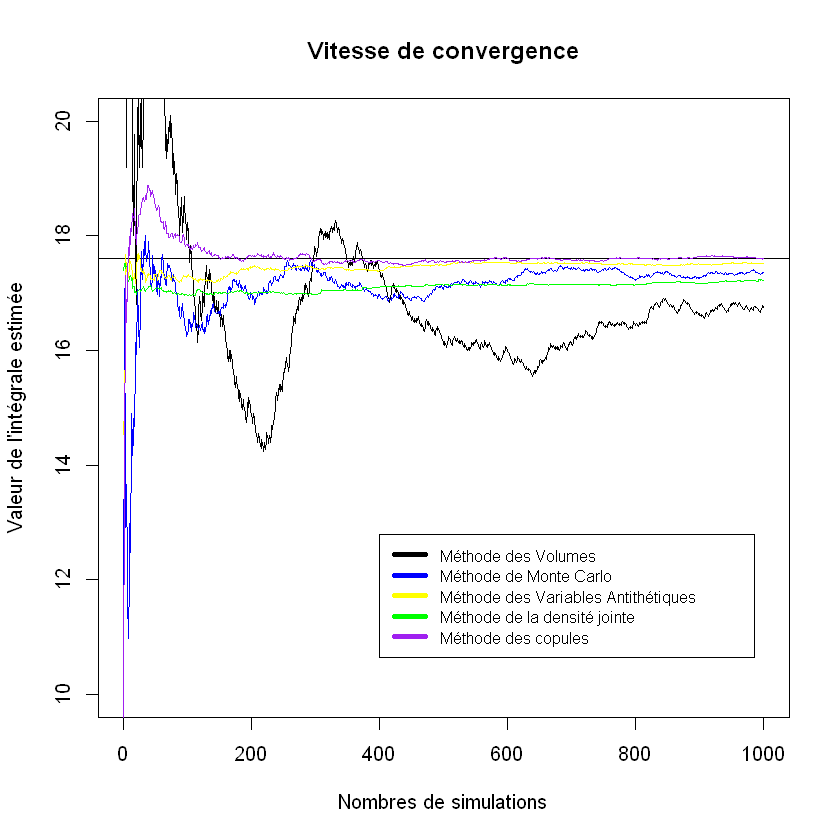

In [42]:
# "Vrai valeur de l'intégrale de h
print(paste("Vraie valeur de l'intégrale de h : ", H),quote=FALSE)
# On affiche les résultat des approximations
print(paste("Méthode 1:"),quote=FALSE)
print(paste("Valeur de l'intégrale de h : ", Sn1,"biais: ",biais1, " variance", variance1 ),quote=FALSE) 
print(paste("Méthode 2:"),quote=FALSE)
print(paste("valeur de l'intégrale de h estimé par la méthode 2 : ", Sn2,"biais: ",biais2, " variance", variance2),quote=FALSE )
print(paste("Méthode 2.1:"),quote=FALSE)
print(paste("valeur de l'intégrale de h estimé par la méthode 2.1 : ", Sn21,"biais: ", biais21, " variance", variance21),quote=FALSE )
print(paste("Méthode 3:"),quote=FALSE)
print(paste("valeur de l'intégrale de h estimé par la méthode 3 : ", Sn3,"biais: ", biais3, " variance", variance3),quote=FALSE )
print(paste("Méthode 4:"),quote=FALSE)
print(paste("valeur de l'intégrale de h estimé par la méthode 4 : ", Sn4,"biais: ", biais4, " variance", variance4),quote=FALSE )

# On affiche le graph des 5 estimateurs afin d'étudier
# la vitesse de convergence vers la "vrai valeur"
plot(Sn_array1,
     col="gray0",
     type="l",
     ylim=c(10,20),
     #xlim=x(100, n),
     main="Vitesse de convergence",
     xlab="Nombres de simulations",
     ylab="Valeur de l'intégrale estimée")
abline(H, 0)
lines(Sn_array2,type="l", col="blue")
lines(Sn_array21, col="yellow")
lines(Sn_array3, col="green")
lines(Sn_array4, col="purple")

legend(400, 12.8,
       legend=c("Méthode des Volumes",
                "Méthode de Monte Carlo",
                "Méthode des Variables Antithétiques",
                "Méthode de la densité jointe",
                "Méthode des copules"),
       col=c("gray0",
             "blue",
             "yellow",
             "green",
             "purple"),
       lwd=4,
       cex=0.8)

$$\textbf{Conclusion:} $$
On remarque que l'on obtient des résulats cohérants avec ceux attendus. 
Les meilleurs méthodes d'approximation sont :
 * La méthode des Copules
 * La méthode de Monte-Carlo avec variables antithétiques

Ce sont elles qui, à la fois, convergent le plus vite, et dont le biais et la variance sont les plus faibles.
Plus précisement, on peut remarquer que la variance de la méthode MC avec variables antithétiques est plus faible que pour la méthode des Copules, mais que le biais de cette dernière est plus faible : c'est un choix classique entre biais et variance, même si ces deux méthodes sont gloabalement équivalentes.
Surtout, celà est peut être dû au fait que nous avons dû "choisir" une Copule pour approximer notre fonction, qui n'est peut être pas la meilleure possible.

La méthode de Monte-Carlo simple finira probablement par donner les mêmes valeurs de biais et de variance que la méthode avec variables antithétiques, mais avec un plus grand nombre de simulations (sa vitesse de convergence est plus faible).

En ce qui concerne la méthode de la densité jointe, on peut constater une vitesse de convergence trés rapide, mais présentant un biais important.
Ceci est principalement dû au fait que nous ayons dû approximer les densités des variables x et y par des fonctions affines, et qui ne sont probablement pas les meilleurs estimations possibles.

Enfin, la méthode des volumes, comme on peut s'y attendre, présente une faible vitesse de convergence, avec un biais et une variance très importante.